<a href="https://colab.research.google.com/github/Jarvis-X/Aerial-Robotics-Course-Projects/blob/main/CS498HW7OmniPlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we import the libraries.

In [ ]:
try:
    import sim
    import numpy as np
    import time
    import matplotlib.pyplot as plt
except:
    print('--------------------------------------------------------------')
    print('Library loading failed!')
    print('')


Then create the Robot class. I changed the class name to be captalized to satisfy PEP8 convention.

I also modified `close_connection()` so that upon disconnection, the robot can stop actuating.

## Notes
* A helper function, `quat2rot(quat)` was implemented to convert the quaternion to the rotation matrix.

* A `Robot` class member function `_cal_design_matrix` was implemented to calculate the design matrix and the null space of that design matrix. Because numpy does not provide null-space calculation, we also implemented `null_space` function for the purpose of non-negative actuation calculation.

* `vee_map` converts a skew symmetric matrix to a vector. We implemented this function to use the SO(3) controller.

* I changed the data accquisition and set signal methods to `simx_opmode_oneshot` which significantly improves the performance.


In [ ]:
class Robot:
    def __init__(self, frame_name, motor_names=None, client_id=0):
        # If there is an existing connection
        if client_id:
            self.client_id = client_id
        else:
            self.client_id = self.open_connection()

        self.motors = self._get_handlers(motor_names)

        # Robot frame
        self.frame = self._get_handler(frame_name)
        self._cal_design_matrix()
        if self.motors:
            self.inv_A = np.linalg.pinv(self.A)

    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

        if self.client_id != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return self.client_id

    def close_connection(self):
        self.actuate([0]*len(self.motors))
        # Before closing the connection of CoppeliaSim,
        # make sure that the last command sent out had time to arrive.
        sim.simxGetPingTime(self.client_id)
        sim.simxFinish(self.client_id)  # Now close the connection of CoppeliaSim:
        print('Connection closed')

    def is_connected(self):
        c, result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0

    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        if err_code != 0:
            print("ERROR: CANNOT GET HANDLER FOR OBJECT '{}'".format(name))
        return handler

    def _get_handlers(self, names):
        handlers = []
        if names is not None:
            for name in names:
                handler = self._get_handler(name)
                handlers.append(handler)

        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id,
                                                      motor, vel, sim.simx_opmode_streaming)

            if err_code != 0:
                print("ERROR: CANNOT SET MOTOR {} WITH VELOCITY {}".format(motor, vel))

    def set_position(self, position, relative_object=-1):
        # By default, get the position wrt the reference frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        err_code = sim.simxSetObjectPosition(self.client_id, self.frame,
                                             relative_object, position, sim.simx_opmode_oneshot)
        if err_code != 0:
            print("ERROR: CANNOT SET POSITION W.R.T. {} TO {}".format(relative_object, position))

    def set_orientation(self, orientation, relative_object=-1):
        # By default, get the position wrt the reference frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        err_code = sim.simxSetObjectOrientation(self.client_id, self.frame,
                                                relative_object, orientation, sim.simx_opmode_oneshot)
        if err_code != 0:
            print("ERROR: CANNOT SET ORIENTATION W.R.T. {} TO {}".format(relative_object, orientation))

    def sim_time(self):
        return sim.simxGetLastCmdTime(self.client_id)

    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_streaming)
        return np.array(position)

    def get_orientation(self, relative_object=-1):
        # Get orientation relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, euler = sim.simxGetObjectOrientation(self.client_id, self.frame, relative_object, sim.simx_opmode_streaming)
        return np.array(euler)

    def get_quaternion(self, relative_object=-1):
        # Get orientation in quaternion relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, quat = sim.simxGetObjectQuaternion(self.client_id, self.frame, relative_object, sim.simx_opmode_streaming)
        return np.array(quat)

    def get_velocity(self, relative_object=-1):
        # Get velocity relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, velocity, omega = sim.simxGetObjectVelocity(self.client_id, self.frame, sim.simx_opmode_streaming)
        return np.array(velocity), np.array(omega)

    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_streaming)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_streaming)
        return np.array(position)

    def get_object_relative_position(self, object_name):
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_streaming)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_streaming)
        return np.array(position)

    def _cal_design_matrix(self):
        if len(self.motors) == 0:
            print("No propeller. Is it a magic box?")
            return

        km_over_kf = 0.0
        design_matrix = np.zeros([6, len(self.motors)])
        null_basis = np.zeros([6, 1])

        for i in range(len(self.motors)):
            motor_id = self.motors[i]
            # print(motor_id)
            res, quat_i = sim.simxGetObjectQuaternion(self.client_id, motor_id, self.frame,
                                                    sim.simx_opmode_blocking)
            # print(res)
            R_i = quat2rot(quat_i)
            res, pos_i_iterable = sim.simxGetObjectPosition(self.client_id, motor_id, self.frame,
                                                          sim.simx_opmode_blocking)
            # print(res)
            pos_i = np.array(pos_i_iterable)
            f_i = R_i.dot(np.array([0, 0, 1]))
            tau_i = np.cross(pos_i, f_i) + km_over_kf*f_i
            design_matrix[:, i] = np.concatenate([f_i, tau_i])

        # print(design_matrix)
        if np.linalg.matrix_rank(design_matrix) == 6:
            print("Fully actuated!")
            ns = null_space(design_matrix)
            ns_std = np.inf
            for i in range(ns.shape[1]):
                if (ns[:, i] > 0).all():
                    if ns_std == np.inf:
                        print("Omnidirectional with unidirectional motors")
                    if np.std(ns[:, i]) < ns_std:
                        null_basis = ns[:, i]
                        ns_std = np.std(ns[:, i])

        self.A = design_matrix
        self.ns = null_basis

    def set_signal(self, signal, value):
        return sim.simxSetFloatSignal(self.client_id, signal, value, sim.simx_opmode_oneshot)

    def actuate(self, u):
        thruster_names = ['f{}'.format(i+1) for i in range(len(self.motors))]
        for fi, ui in zip(thruster_names, u):
            self.set_signal(fi, ui)


def quat2rot(quat):
    # Covert a quaternion into a full three-dimensional rotation matrix.
    # Extract the values from quat
    q0 = quat[3]
    q1 = quat[0]
    q2 = quat[1]
    q3 = quat[2]

    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)

    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)

    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1

    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])

    return rot_matrix


def vee_map(skew_s):
    # convert a skew-symmetric matrix to the corresponding array
    return np.array([skew_s[2, 1], skew_s[0, 2], skew_s[1, 0]])


# Wow, numpy does not have null space :(
def null_space(A, rcond=None):
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    M, N = u.shape[0], vh.shape[1]
    if rcond is None:
        rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond
    num = np.sum(s > tol, dtype=int)
    Q = vh[num:, :].T.conj()
    return Q


Run the simulation until we Ctrl+C

## Notes
* We implemented a trajectory which is described on lines 24-25.
* We inluded an integral term in attitude control to compensate the drifting issue.
* $\mathsf{SO(3)}$ controller lock and load

In [ ]:
# number of propellers
    r = Robot('MultiRotor', motor_names=['propeller{:01d}'.format(i+1) for i in range(8)])
    d = Robot('DesiredBox')

    m = 8.8  # kg mass of the block plus the mass of the prop
    g = 9.81
    inertia = 0.1

    log_p = []
    log_R = []
    log_time = []
    log_u = []
    log_rpy = []
    log_th = []
    log_tor = []

    try:
        cap_R_i = 5.0
        e_R_i = np.array([0.0, 0.0, 0.0])

        simulation_start = time.time()
        while True:
            time_start = time.time()
            d.set_position(np.array([np.cos(time_start/2), np.sin(time_start/2.5), 0.7+0.2*np.cos(time_start/3)]))
            d.set_orientation(0.3*np.array([np.cos(time_start/1.5), np.sin(time_start/2.1), np.cos(time_start/1.8)]))
            # d.set_orientation(np.array([time_start/10.0, 0, 0]))
            # Robot state
            p = r.get_position()
            v, omega = r.get_velocity()
            rpy = r.get_orientation()
            R = quat2rot(r.get_quaternion())
            R_d = quat2rot(d.get_quaternion())

            # Desired state
            p_d = d.get_position()
            v_d, omega_d = d.get_velocity()
            rpy_d = d.get_orientation()

            # errors
            ep = p_d - p
            ev = v_d - v

            erpy = rpy_d - rpy
            for i in range(len(erpy)):
                if erpy[i] <= -np.pi:
                    erpy[i] += 2 * np.pi
                elif erpy[i] > np.pi:
                    erpy[i] -= 2 * np.pi

            eR = 1/2*vee_map(R_d.T.dot(R)-R.T.dot(R_d))

            e_R_i += eR
            for i in range(len(e_R_i)):
                if e_R_i[i] > cap_R_i:
                    e_R_i[i] = cap_R_i
                elif e_R_i[i] < -cap_R_i:
                    e_R_i[i] = -cap_R_i

            eomega = omega_d - omega

            # PD control
            # PD control for 8-propellers
            kp, kd = 10.0, 4.5
            ar = kp * ep + kd * ev

            kp_rp, kd_rp, ki_rp = 50.0, 9.0, 4.0
            kp_y, kd_y, ki_y = 30.0, 25.0, 1.0

            aR = np.concatenate([-kp_rp * eR[:2] + kd_rp * eomega[:2] - ki_rp * e_R_i[:2],
                                 np.array([-kp_y * eR[2] + kd_y * eomega[2] -ki_y * eR[2]])])

            '''
            # PD control for 16-propellers
            kp, kd = 5.0, 3.2
            ar = kp * ep + kd * ev

            kp_rp, kd_rp = 25.0, 5.0
            kp_y, kd_y = 40.0, 25.0

            aR = np.concatenate([-kp_rp * eR[:2] + kd_rp * eomega[:2], np.array([-kp_y * eR[2] + kd_y * eomega[2]])])
            '''

            f = m * ar
            f[2] += m * g
            f = R.T.dot(f)
            tau = inertia * aR

            w = np.concatenate([f, tau])
            log_th.append(R.dot(w[:3]))
            log_tor.append(w[3:])

            u_crude = r.inv_A.dot(w)
            u = u_crude

            if not (u_crude >= 0).all() and (r.ns > 0).all():
                min_force_div = 0
                for i in range(len(u_crude)):
                    if u_crude[i]/r.ns[i] < min_force_div:
                        min_force_div = u_crude[i]/r.ns[i]

                u = u_crude - r.ns * min_force_div
                # for i in range(len(u)):
                #     if u[i] > 500:
                #         u[i] = 500
                r.actuate(u.tolist())
            else:
                for i in range(len(u_crude)):
                    if u_crude[i] < 0:
                        u_crude[i] = 0

                r.actuate(u_crude.tolist())

            # r.wrench([f[0], f[1], f[2], 0, 0, 0])

            log_p.append(ep)
            log_R.append(eR)
            log_rpy.append(erpy)
            log_u.append(u)
            log_time.append(time.time() - simulation_start)
            print(time.time() - time_start)
            while time.time() - time_start < 0.05:
                time.sleep(0.001)

    except KeyboardInterrupt:
        r.close_connection()

In [ ]:
    log_p = np.array(log_p)
    log_R = np.array(log_R)
    log_rpy = np.array(log_rpy)
    log_u = np.array(log_u)
    log_th = np.array(log_th)
    log_tor = np.array(log_tor)
    log_time = np.array(log_time)

    fig = plt.figure()
    ax1 = fig.add_subplot(231)
    ax1.grid()
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('position error (m)')
    ax1.set_title('position error v.s. time')
    ax1.plot(log_time, log_p[:, 0], label='$e_x$')
    ax1.plot(log_time, log_p[:, 1], label='$e_y$')
    ax1.plot(log_time, log_p[:, 2], label='$e_z$')
    ax1.legend()

    ax2 = fig.add_subplot(232)
    ax2.grid()
    ax2.set_xlabel('time (s)')
    ax2.set_title('orientation error v.s. time')
    ax2.plot(log_time, log_R[:, 0], label='$e_{roll}$')
    ax2.plot(log_time, log_R[:, 1], label='$e_{pitch}$')
    ax2.plot(log_time, log_R[:, 2], label='$e_{yaw}$')
    ax2.legend()

    ax3 = fig.add_subplot(234)
    ax3.grid()
    ax3.set_xlabel('time (s)')
    ax3.set_title('input forces v.s. time')
    for i in range(len(r.motors)):
        ax3.plot(log_time, log_u[:, i], label='$u_{}$'.format(i+1))
    ax3.legend()

    ax4 = fig.add_subplot(235)
    ax4.grid()
    ax4.set_xlabel('time (s)')
    ax4.set_title('rpy error v.s. time')
    ax4.plot(log_time, log_rpy[:, 0], label='$e_{roll}$')
    ax4.plot(log_time, log_rpy[:, 1], label='$e_{pitch}$')
    ax4.plot(log_time, log_rpy[:, 2], label='$e_{yaw}$')
    ax4.legend()

    ax5 = fig.add_subplot(233)
    ax5.grid()
    ax5.set_xlabel('time (s)')
    ax5.set_title('des thrust in W v.s. time')
    ax5.plot(log_time, log_th[:, 0], label='$f_x$')
    ax5.plot(log_time, log_th[:, 1], label='$f_y$')
    ax5.plot(log_time, log_th[:, 2], label='$f_z$')
    ax5.legend()

    ax4 = fig.add_subplot(236)
    ax4.grid()
    ax4.set_xlabel('time (s)')
    ax4.set_title('des torque in B v.s. time')
    ax4.plot(log_time, log_tor[:, 0], label='$tau_{roll}$')
    ax4.plot(log_time, log_tor[:, 1], label='$tau_{pitch}$')
    ax4.plot(log_time, log_tor[:, 2], label='$tau_{yaw}$')
    ax4.legend()


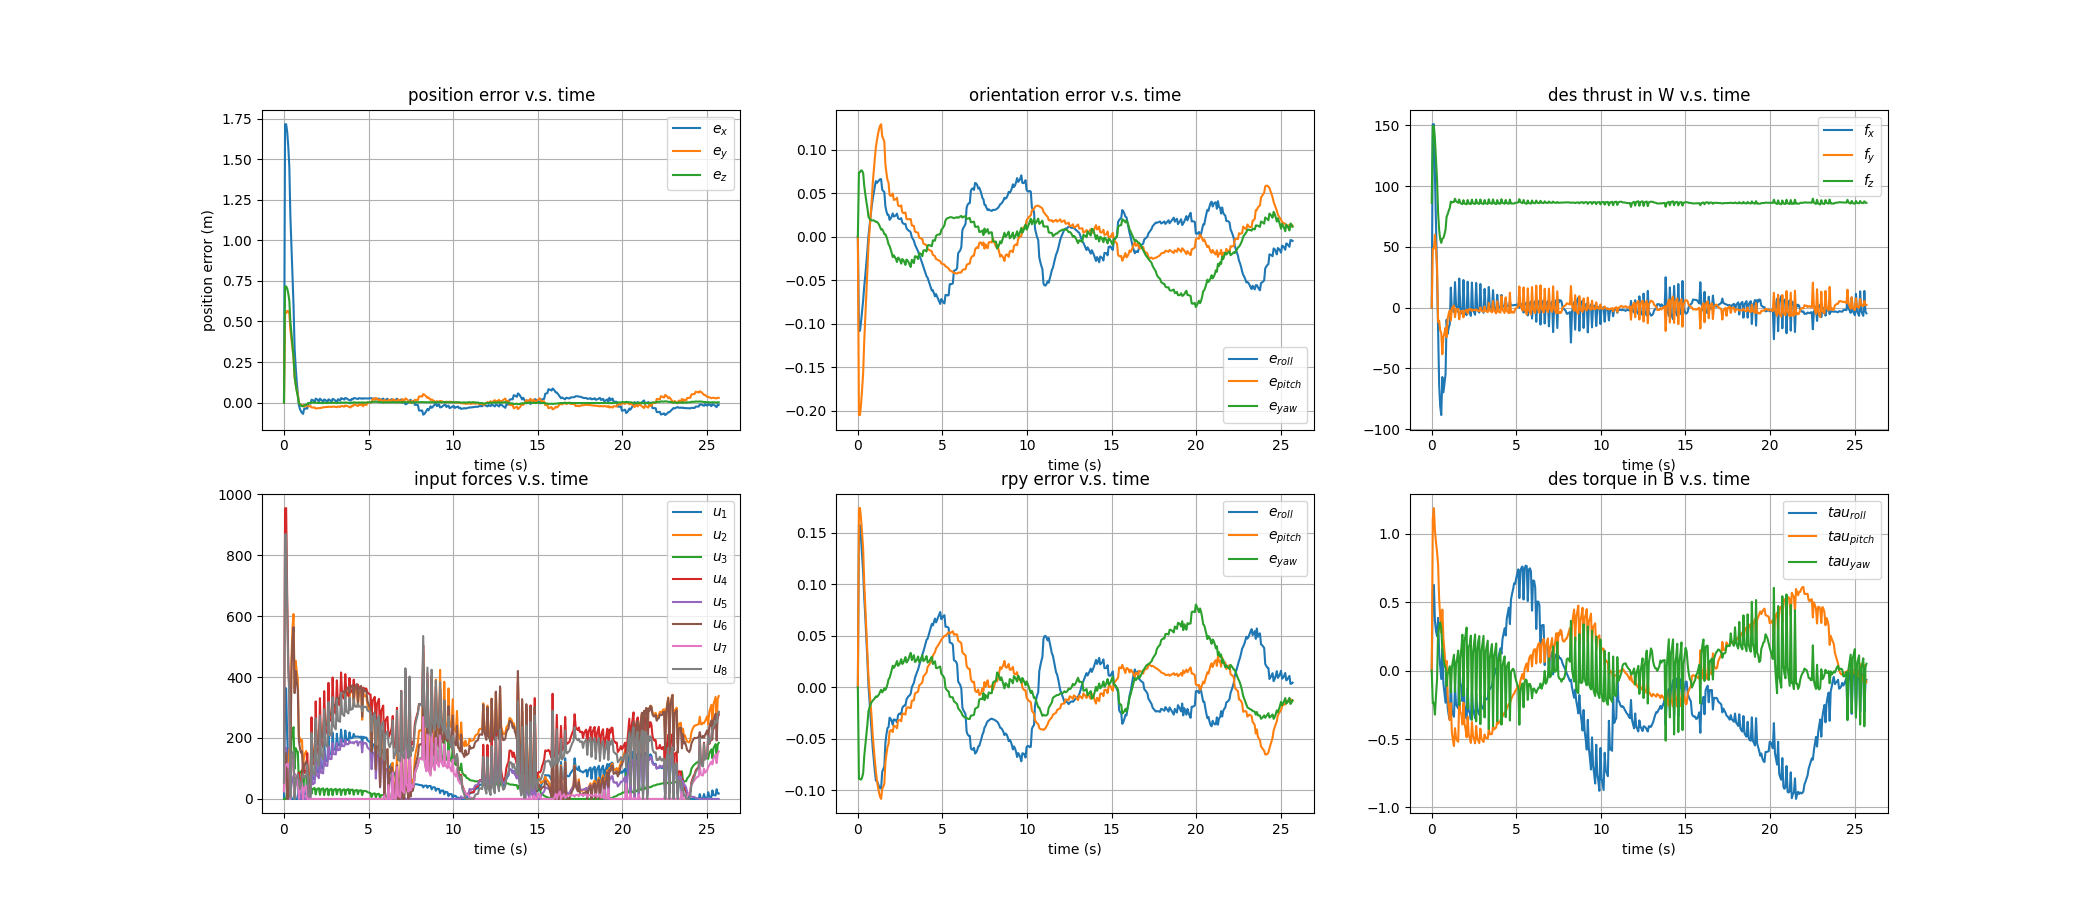